# Notebook: NLP with LLMs
---

Part of the [Masterclass: Large Language Models for Data Science](https://github.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science)
![](https://raw.githubusercontent.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science/refs/heads/main/slides/Day_1/figures/pair-programming-with-llms.webp)
by Alex van Vorstenbosch
---

Check out the prompting cheatsheet for prompt inspiration: **Cheatsheet.pdf**!\
It can be found in the course material under **./slides/**.

It contains some example prompts and inspiration for all kinds of prompting tasks. Read it before starting on the assingments below.

If you want some more information about google colab and the different LLM models you can use, check out the **[general colab notebook](https://colab.research.google.com/drive/1LnsvqzL8BjO3m52siYJpakS-uR64B9pI?usp=sharing)**


# Sentiment Analysis

In this Exercise set, we are going to use an LLM for a sentiment analysis problem. We'll be using some functions and lessons learnt in previous lectures.


# 1. Setup

First we will need to install the necessary python packages.
Luckily for us, google colab comes with most of the libraries and requiered cuda software already pre-installed.

## 1.1 Runtime
---

We will want to use a GPU to run the examples in this notebook. In Google Colab, go to the menu bar:


**Menu bar > Runtime > Change runtime type > T4 GPU**

---

## 1.2 Install packages
Run the cell below to install `llama-cpp-python` which allows fast inference on GPU and CPU with GGUF quantized models.



In [ ]:
# %% capture
!pip install --no-cache-dir llama-cpp-python==0.3.4 --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu122

Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu122
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.2/445.2 MB 235.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00


## 1.3 Load libraries

In [ ]:
import pandas as pd
from IPython.display import display
import json
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from llama_cpp.llama import Llama

## 1.4 Load helper functions from github

In the repo I have included 2 helper functions for talking to LLMs:

1. generate_response\
   Generate a response given a set of chat messages, with optional streaming behavior.

2. interactive_chat\
   Allows the user to engage in an interactive chat session with the model (streaming by default).


In [ ]:
!curl -o helper_functions.py https://raw.githubusercontent.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science/refs/heads/course_2025/exercises/day_1/helper_functions/helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7910  100  7910    0     0  41586      0 --:--:-- --:--:-- --:--:-- 41631


In [ ]:
from helper_functions import *


## 2 Read the data
The dataset contains 500 sentences of the SemEval2014-restaurants dataset. This is a dataset for ABSA:\
"Aspect Based Sentiment Analysis": Given all the aspects (red: relevant elements) detect the sentiment expressed about them.

There are 2 flavours of ABSA:

- regular ABSA: Aspect Based Sentiment Analysis - Detect the sentiment for each aspect given.
- E2E-ABSA: End-to-End Aspect Based Sentiment Analysis - Detect both the aspects and their sentiment.

E2E is significantly harder to achieve, and to a higher degree depends on the labeling quality of the data set.
For this exercise set, we will be performing regular ABSA using an LLM.

In [ ]:
# Download the data onto google colab
!curl --create-dirs -O --output-dir  ./data/ https://raw.githubusercontent.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science/refs/heads/gh_pages/slides/Day_2/exercises/data/semEval2014-restaurants-x.csv
!curl -O --output-dir ./data/ https://raw.githubusercontent.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science/refs/heads/gh_pages/slides/Day_2/exercises/data/semEval2014-restaurants-y.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43127  100 43127    0     0   228k      0 --:--:-- --:--:-- --:--:--  228k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20059  100 20059    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k


In [ ]:
# Read the data
data_x = pd.read_csv("./data/semEval2014-restaurants-x.csv", delimiter=";")
data_y = pd.read_csv("./data/semEval2014-restaurants-y.csv", delimiter=";")


# DON'T TOUCH THIS CODE ---------------------##
# We need everybodies data_test to be equal  ##
# --------------------------------------------##
# Not all sentences in the dataset have a y-label in the original data set
# in this cleaned sample they do
data = pd.merge(data_x, data_y, on="sentence_id", how="inner")

# Add a new column 'new_id' for grouping
data["new_id"] = data.groupby("sentence_id").ngroup()

# Create data_train and data_test DataFrames
data_train = data[data["new_id"] <= 400].drop(columns="new_id")
data_test = data[data["new_id"] > 400].drop(columns="new_id")

# --------------------------------------------##

### Check out the data, what does it look like

In [ ]:
print("The X data:\n", data_x.head(5))
print("\n\nThe Y data:\n", data_y.head(5))

The X data:
    sentence_id                                      sentence_text
0         1634  The food is uniformly exceptional, with a very...
1         1458  Our agreed favorite is the orrechiete with sau...
2         1793  It took half an hour to get our check, which w...
3         1407  The seats are uncomfortable if you are sitting...
4         1623                        The wine list is excellent.


The Y data:
    sentence_id                          aspect_term  polarity
0         1634                                 food  positive
1         1634                              kitchen  positive
2         1634                                 menu   neutral
3         1458  orrechiete with sausage and chicken  positive
4         1458                              waiters  positive


# 3 ABSA

Here we will try our hand at sentiment analysis using an out-of-the-box LLM.\
\
*IMPORTANT-RULE:*\
You are allowed to do whatever you want with the training data.
Play with it, experiment with it, etc. But you are only allowed to touch the test-data when we evaluate our model performance.
If you need to alter the format of data_test for your prompt, that is allowed, but other than that, you cannot touch it!
We will see who get's the highest test-performance at the end of the session.

## 3.1 Zero-shot - Single

At this point, we are going to try performing Zero-shot sentiment analysis. The rules are simple:

- The model response should contain the prediction for all aspects in the same sentence at once.
- You are not allowed to provide any sentiment analysis examples to the model.
- You are allowed to describe the various sentiment polarities and their definition.
- You are free to write this prompt as you see fit, just don't give examples.
- You can decide how to distribute the prompt over the system_prompt and the user_prompt.
- Check out the labeling rules guide for SemEval: [SemEval14_ABSA_AnnotationGuidelines.pdf](https://alt.qcri.org/semeval2014/task4/data/uploads/semeval14_absa_annotationguidelines.pdf)
- Make it easy for yourself: use the json mode for easy extraction of the classifications!

**Example:**\
Here is an example to demonstrate what the data looks like, and what the expected output is.

Targets:

- sentence: "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not."
- aspects: food, kitchen, menu
- sentiment: positive, positive, neutral

Output:

- {"food": "positive", "kitchen": "positive", "menu": "neutral"}

Let us start with classifying the sentiment for a single example sentence.

In [ ]:
# ## Uncomment and run this cell if you need to clear the GPU memory!
# import gc
# import torch
# del llm

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# Load you llm model
llm = Llama.from_pretrained(
    # Huggingface repo name
    repo_id="bartowski/Meta-Llama-3.1-8B-Instruct-GGUF",
    # select the quant file within the repo you want '*' is a wildcard selector
    filename="*Q6_K.gguf",
    n_gpu_layers=-1,
    n_ctx=32518, # this is 50 A4 pages of context window!
    verbose=False,
    logits_all=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


Meta-Llama-3.1-8B-Instruct-Q6_K.gguf:   0%|          | 0.00/6.60G [00:00<?, ?B/s]

llama_new_context_with_model: n_ctx_per_seq (32544) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [ ]:
# this notation is a bit weird
# It's a trick to delay the f string evaluation
# Now you can call user_prompt() within a loop to get the current correct values
# We only apply this to the user_prompt as the system_prompt should not change between different inputs.
system_prompt = """
Classify the sentiment for each aspect term given for a sentence.

Each sentence contains one or more **aspect terms**, which are single or multiword phrases referring to specific aspects of the target entity.
The goal is to assign a **sentiment polarity** to each aspect term in the sentence.
The aspects are presented as part of the task, do not introduce your own aspects.

## Guidelines

- Assign **one** of the following sentiment polarities to each aspect term:
  - **positive**: The aspect is described favorably.
  - **negative**: The aspect is described unfavorably.
  - **conflict**: The aspect has both positive and negative sentiment.
  - **neutral**: The aspect is mentioned but without clear sentiment.
- The response must include **all aspects in the sentence at once**.
- **Use JSON format** for easy extraction.

## Output Format

Return the response in **JSON format**, where:
- Each **aspect term** is a key.
- The corresponding **sentiment polarity** is the value.

### Example
#### Output JSON:
{
  "food": "positive",
  "kitchen": "positive",
  "menu": "neutral"
}

Only use the exact aspect names as in the input. Only return the aspect and the predicted sentiment in the json, nothing else.
"""

user_prompt = lambda: f"""
Input sentence: '{target_sentence}'
aspects: '{target_aspect_terms_combined}'
"""

In [ ]:
# use these variables in your F-string
i = 1
x_sentence_id = data_train.loc[i, "sentence_id"]
target_sentence = data_train.loc[i, "sentence_text"]

targets = data_train[data_train['sentence_id'] == x_sentence_id]
target_aspect_terms_combined = ", ".join(targets.aspect_term)

In [ ]:
# Generate a classification
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt()}
]
response_raw = generate_response(llm, messages, json_mode=True, temperature=0)

### Check if the predictions where correct

In [ ]:
# Read classifications from response
response_classification = json.loads(response_raw)

# Check correctness for each prediction
results = []
for i,aspect in enumerate(response_classification):
    result_i = response_classification[aspect] == (targets.polarity[targets.aspect_term == aspect]).values[0]
    results.append(result_i)

print(results)

[True, True, True]


You can play around a bit here, to test your prompt on individual examples. In the next section, I've supplied code you can use to test your prompt on multiple examples at once.

## Zero-shot - Multiple examples

Now we'll do a bigger trial run on the training data. Below I've written some code that puts all the data of the first 50 sentences into a single
dataframe and runs predictions. You should finish the `get_predicitions` function to get predictions for every sentence in data_train

In [ ]:
n_samples = 100 # Select your number

# Add a new column 'new_id' for grouping
data_train_sample = data_train
data_train_sample['new_id'] = data_train_sample.groupby('sentence_id').ngroup()

# Create data_train_sample_train and data_train_sample_test data_train_sampleFrames
data_train_sample= data_train_sample[data_train_sample['new_id'] <= n_samples].drop(columns='new_id')

def predict_sentiment(system_prompt = system_prompt, user_prompt = user_prompt):
  #' A simple wrapper function for generate completion that extracts the sentiment from the response
  #' Please modify to your own liking!
  messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt()}
  ]
  response = generate_response(llm, messages, json_mode=True, temperature=0)
  return(json.loads(response))


# We're making predictions in a for loop, and appending them to a dataframe
# Not elegant or vectorised, but easy to understand.
# please note: running this takes a while to finish...
sentence_ids = data_train_sample['sentence_id'].unique()
predictions_train = pd.DataFrame(columns=['sentence_id', 'aspect_term', 'polarity_prediction'])

for target_sentence_id in sentence_ids:
    targets = data_train_sample[data_train_sample['sentence_id'] == target_sentence_id]
    target_sentence = targets.iloc[0]['sentence_text']

    target_aspect_terms_combined = ', '.join(targets['aspect_term'])

    # Assuming predict_sentiment is a function you have defined
    prediction = predict_sentiment(system_prompt, user_prompt)

    for aspect, polarity in prediction.items():
        temp_df = pd.DataFrame({
            'sentence_id': [target_sentence_id],
            'aspect_term': [aspect],
            'polarity_prediction': [polarity]
        })
        predictions_train = pd.concat([predictions_train, temp_df], ignore_index=True)

Bring them together so we can evaluate the accuracy

In [ ]:
data_train_p = pd.merge(
    data_train_sample, predictions_train, how="left", on=["sentence_id", "aspect_term"]
).dropna()

# Drop predictions that are not formatted correctly
data_train_p = data_train_p[data_train_p["polarity_prediction"].apply(lambda x: isinstance(x, str))]


In [ ]:
predictions_train

,sentence_id,aspect_term,polarity_prediction
0,1074,Dosa,positive
1,183,service,conflict
2,148,rice dishes,positive
3,148,congee (rice porridge),neutral
4,173,Food,positive
...,...,...,...
176,137,place,positive
177,1027,bottle of sake,neutral
178,1027,edamames,positive
179,1027,sushi plate,neutral


### Evaluation Metrics

In this section you can evaluate the performance of your model. You will get:

- The accuracy
- Class level: Precision, Recall, Specificity

In [ ]:
# get true and false
y_true = data_train_p["polarity"]
y_pred = data_train_p["polarity_prediction"]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Extracting metrics
accuracy = accuracy_score(y_true, y_pred)

# Calculate the baseline accuracy
baseline_accuracy = data_train["polarity"].value_counts().max() / len(data_train)

# Print the metrics
print(
    f"The baseline accuracy (predicting majority class): {round(baseline_accuracy, 3)}"
)
print(
    f"Micro Accuracy = Micro Precision = Micro Recall = Micro F1: {round(accuracy, 3)}"
)

# Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, digits=3))

The baseline accuracy (predicting majority class): 0.58
Micro Accuracy = Micro Precision = Micro Recall = Micro F1: 0.798
              precision    recall  f1-score   support

    conflict      0.200     0.400     0.267         5
    negative      0.825     0.892     0.857        37
     neutral      0.556     0.370     0.444        27
    positive      0.882     0.890     0.886       109

    accuracy                          0.798       178
   macro avg      0.616     0.638     0.614       178
weighted avg      0.801     0.798     0.796       178



### Confusion matrix

This code takes as input your confusion_matrix to turn it into a plot.

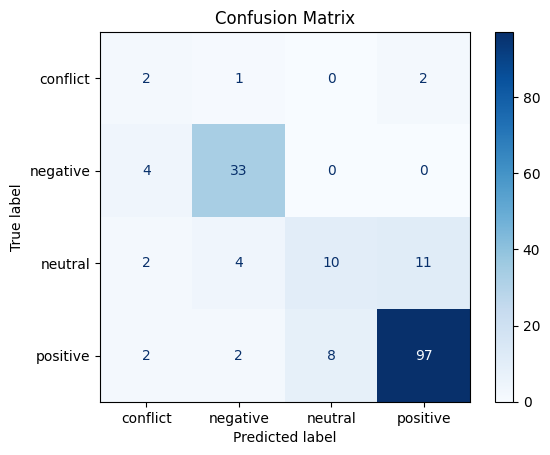

In [ ]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=[
        "conflict",
        "negative",
        "neutral",
        "positive",
    ],
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Inspect the wrong predictions

Please check what the examples where the model got wrong.:

In [ ]:
data_train_p[data_train_p["polarity"] != data_train_p["polarity_prediction"]]

,sentence_id,sentence_text,aspect_term,polarity,polarity_prediction
0,1074,I grew up eating Dosa and have yet to find a p...,Dosa,neutral,positive
3,148,I also recommend the rice dishes or the differ...,congee (rice porridge),positive,neutral
4,173,"Food is usually very good, though ocasionally ...",Food,conflict,positive
8,139,The food here does a great service to the name...,Cantonese,positive,neutral
11,128,"If you want some roast duck, pork or chicken o...",chicken on rice with ginger,positive,neutral
25,133,The atmosphere is noisy and the waiters are li...,waiters,conflict,positive
34,1013,By far this is the only chinese desserts place...,pig feet ginger simmered in black vinegar,positive,negative
46,1032,"Whenever you need a Sushi fix, Mizu will be th...",Sushi fix,positive,neutral
48,175,The decor is vibrant and eye-pleasing with sev...,dining hall,positive,neutral
51,1007,They don't walk around with the trays of Dim Sum.,trays of Dim Sum,neutral,negative


Please check if there were examples where the model returned the wrong aspect label:

In [ ]:
merge = pd.merge(data_train_sample, predictions_train, on=["sentence_id", "aspect_term"], how='outer', indicator=True)
wrong_aspects = merge[merge["_merge"]=="right_only"]
merge[merge["sentence_id"].isin(wrong_aspects["sentence_id"].values)]

,sentence_id,sentence_text,aspect_term,polarity,polarity_prediction,_merge
61,164,The entire place and the treatment we received...,place,negative,negative,both
62,164,NaN,treatment,NaN,negative,right_only
142,1040,"So, for good food i'd recommend it, but not fo...",food,positive,positive,both
143,1040,NaN,fun night out,NaN,negative,right_only


The model corrects misspelled words in the current version, and it sometimes splits terms into 2 or more terms where it shouldn't

## Zero-shot - Test
You can still iterate over your zero-shot prompt above, using all the information from the train set, or using a larger sample of the training-data.
If you are ready to test yourself, run the cell below to evaluate your model on the test-set.

**YOU ARE ONLY ALLOWED TO DO THIS ONCE, THIS WILL BE YOUR FINAL SCORE ON THE ZERO-SHOT EXERCISE**

The baseline accuracy (predicting majority class): 0.58
Micro Accuracy = Micro Precision = Micro Recall = Micro F1: 0.716
              precision    recall  f1-score   support

    conflict      0.000     0.000     0.000         4
    negative      0.696     0.780     0.736        41
     neutral      0.333     0.167     0.222        30
    positive      0.831     0.925     0.876        80

    accuracy                          0.716       155
   macro avg      0.465     0.468     0.458       155
weighted avg      0.678     0.716     0.690       155



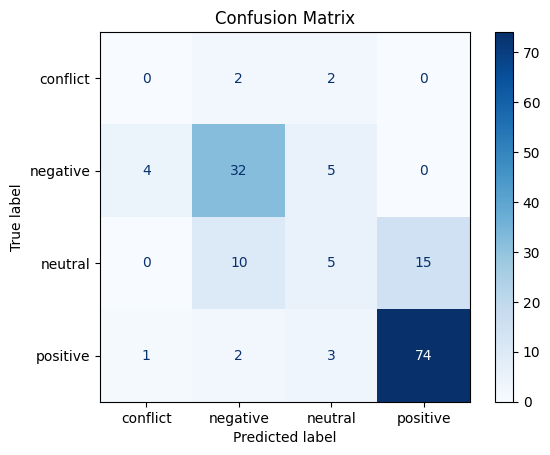

In [ ]:
# We're making predictions in a for loop, and appending them to a dataframe
# Not elegant or vectorised, but easy to understand.
# please note: running this takes a while to finish...

sentence_ids = data_test["sentence_id"].unique()
predictions_test = pd.DataFrame(
    columns=["sentence_id", "aspect_term", "polarity_prediction"]
)

for target_sentence_id in sentence_ids:
    targets = data_test[data_test["sentence_id"] == target_sentence_id]
    target_sentence = targets.iloc[0]["sentence_text"]

    target_aspect_terms_combined = ", ".join(targets["aspect_term"])

    # Assuming predict_sentiment is a function you have defined
    prediction = predict_sentiment(system_prompt, user_prompt)

    for aspect, polarity in prediction.items():
        temp_df = pd.DataFrame(
            {
                "sentence_id": [target_sentence_id],
                "aspect_term": [aspect],
                "polarity_prediction": [polarity],
            }
        )
        predictions_test = pd.concat([predictions_test, temp_df], ignore_index=True)

data_test_p = pd.merge(
    data_test, predictions_test, how="left", on=["sentence_id", "aspect_term"]
).dropna()

# get true and false
y_true = data_test_p["polarity"]
y_pred = data_test_p["polarity_prediction"]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Extracting metrics
accuracy = accuracy_score(y_true, y_pred)

# Print the metrics
print(
    f"The baseline accuracy (predicting majority class): {round(baseline_accuracy, 3)}"
)
print(
    f"Micro Accuracy = Micro Precision = Micro Recall = Micro F1: {round(accuracy, 3)}"
)

# Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, digits=3))

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=[
        "conflict",
        "negative",
        "neutral",
        "positive",
    ],
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Few-shot - Training

Now adjust your system prompt, use examples to demonstrate how labels should be given.
You can only use examples from the training set, or examples that you thought of yourself.

In [ ]:
data_train.head(10)

,sentence_id,sentence_text,aspect_term,polarity,new_id
0,1634,"The food is uniformly exceptional, with a very...",food,positive,387
1,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,387
2,1634,"The food is uniformly exceptional, with a very...",menu,neutral,387
3,1458,Our agreed favorite is the orrechiete with sau...,orrechiete with sausage and chicken,positive,289
4,1458,Our agreed favorite is the orrechiete with sau...,waiters,positive,289
5,1458,Our agreed favorite is the orrechiete with sau...,meats,neutral,289
6,1458,Our agreed favorite is the orrechiete with sau...,dish,neutral,289
9,1407,The seats are uncomfortable if you are sitting...,seats,negative,261
10,1623,The wine list is excellent.,wine list,positive,380
11,1101,They wouldnt even let me finish my glass of wi...,glass of wine,neutral,108


In [ ]:
def predict_sentiment(system_prompt = system_prompt, user_prompt = user_prompt):
    #' A simple wrapper function for generate completion that extracts the sentiment from the response
    #' Please modify to your own liking!
    messages=[
      {
          "role": "system",
          "content": system_prompt,
      },
      {
          "role": "user",
          "content":"""
    Input sentence: 'The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.'
    aspects: '{food, kitchen, menu}'
    """
      },
      {
          "role": "assistant",
          "content":"""
    {"food": "positive", "kitchen": "positive", "menu": "neutral"}
      """
      },
      {
          "role": "user",
          "content":"""
    Input sentence: 'Our agreed favorite is the orrechiete with sausage and chicken (usually the waiters are kind enough to split the dish in half so you get to sample both meats).'
    aspects: '{orrechiete with sausage and chicken, waiters, meats, dish}'
    """
      },
      {
          "role": "assistant",
          "content":"""
    {"orrechiete with sausage and chicken": "positive", "waiters": "positive", "meats": "neutral", "dish": "neutral"}
    """,
      },
      {
          "role": "user",
          "content": user_prompt()
      },
    ]
    response = generate_response(llm, messages, json_mode=True, temperature=0)
    return(json.loads(response))

Here is the same code as before to make predictions, but now you should:

- make sure that you updated the `predict_sentiment` function above

In [ ]:
n_samples = 100 # Select your number

# Add a new column 'new_id' for grouping
data_train_sample = data_train
data_train_sample['new_id'] = data_train_sample.groupby('sentence_id').ngroup()

# Create data_train_sample_train and data_train_sample_test data_train_sampleFrames
data_train_sample= data_train_sample[data_train_sample['new_id'] <= n_samples].drop(columns='new_id')

# We're making predictions in a for loop, and appending them to a dataframe
# Not elegant or vectorised, but easy to understand.
# please note: running this takes a while to finish...
sentence_ids = data_train_sample['sentence_id'].unique()
predictions_train = pd.DataFrame(columns=['sentence_id', 'aspect_term', 'polarity_prediction'])

for target_sentence_id in sentence_ids:
    targets = data_train_sample[data_train_sample['sentence_id'] == target_sentence_id]
    target_sentence = targets.iloc[0]['sentence_text']

    target_aspect_terms_combined = ', '.join(targets['aspect_term'])

    # Assuming predict_sentiment is a function you have defined
    prediction = predict_sentiment(system_prompt, user_prompt)

    for aspect, polarity in prediction.items():
        temp_df = pd.DataFrame({
            'sentence_id': [target_sentence_id],
            'aspect_term': [aspect],
            'polarity_prediction': [polarity]
        })
        predictions_train = pd.concat([predictions_train, temp_df], ignore_index=True)

data_train_p = pd.merge(data_train_sample, predictions_train, how="left", on = ["sentence_id", "aspect_term"]).dropna()

# Drop predictions that are not formatted correctly
data_train_p = data_train_p[data_train_p["polarity_prediction"].apply(lambda x: isinstance(x, str))]

In [ ]:
data_train_p = pd.merge(
    data_train_sample, predictions_train, how="left", on=["sentence_id", "aspect_term"]
).dropna()

# Drop predictions that are not formatted correctly
data_train_p = data_train_p[data_train_p["polarity_prediction"].apply(lambda x: isinstance(x, str))]

# get true and false
y_true = data_train_p["polarity"]
y_pred = data_train_p["polarity_prediction"]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Extracting metrics
accuracy = accuracy_score(y_true, y_pred)

# Calculate the baseline accuracy
baseline_accuracy = data_train["polarity"].value_counts().max() / len(data_train)

# Print the metrics
print(
    f"The baseline accuracy (predicting majority class): {round(baseline_accuracy, 3)}"
)
print(
    f"Micro Accuracy = Micro Precision = Micro Recall = Micro F1: {round(accuracy, 3)}"
)

# Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, digits=3))

The baseline accuracy (predicting majority class): 0.58
Micro Accuracy = Micro Precision = Micro Recall = Micro F1: 0.794
              precision    recall  f1-score   support

    conflict      0.182     0.400     0.250         5
    negative      0.842     0.865     0.853        37
     neutral      0.526     0.370     0.435        27
    positive      0.884     0.892     0.888       111

    accuracy                          0.794       180
   macro avg      0.609     0.632     0.607       180
weighted avg      0.802     0.794     0.795       180



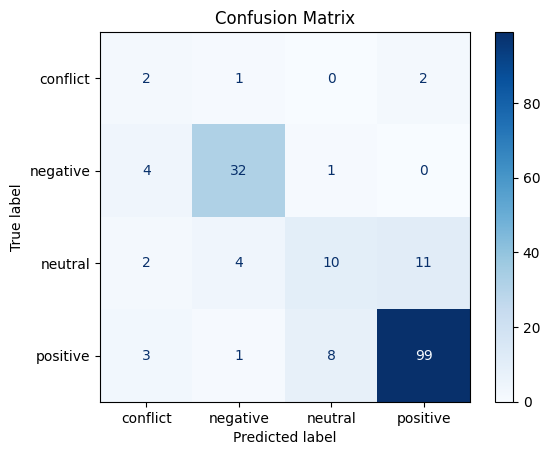

In [ ]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=[
        "conflict",
        "negative",
        "neutral",
        "positive",
    ],
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Few-shot - Test
You can still iterate over your few-shot prompt above, using all the information from the train set, or using a larger sample of the training-data.
If you are ready to test yourself, run the cell below to evaluate your model on the test-set.

**YOU ARE ONLY ALLOWED TO DO THIS ONCE, THIS WILL BE YOUR FINAL SCORE ON THE FEW-SHOT EXERCISE**

The baseline accuracy (predicting majority class): 0.58
Micro Accuracy = Micro Precision = Micro Recall = Micro F1: 0.723
              precision    recall  f1-score   support

    conflict      0.000     0.000     0.000         4
    negative      0.696     0.780     0.736        41
     neutral      0.333     0.167     0.222        30
    positive      0.833     0.938     0.882        80

    accuracy                          0.723       155
   macro avg      0.466     0.471     0.460       155
weighted avg      0.679     0.723     0.693       155



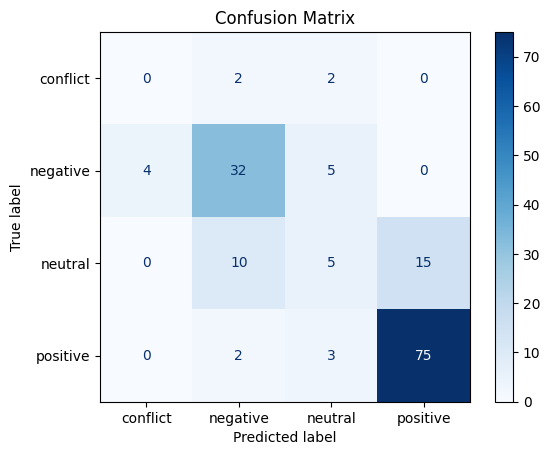

In [ ]:
# We're making predictions in a for loop, and appending them to a dataframe
# Not elegant or vectorised, but easy to understand.
# please note: running this takes a while to finish...

sentence_ids = data_test["sentence_id"].unique()
predictions_test = pd.DataFrame(
    columns=["sentence_id", "aspect_term", "polarity_prediction"]
)

for target_sentence_id in sentence_ids:
    targets = data_test[data_test["sentence_id"] == target_sentence_id]
    target_sentence = targets.iloc[0]["sentence_text"]

    target_aspect_terms_combined = ", ".join(targets["aspect_term"])

    # Assuming predict_sentiment is a function you have defined
    prediction = predict_sentiment(system_prompt, user_prompt)

    for aspect, polarity in prediction.items():
        temp_df = pd.DataFrame(
            {
                "sentence_id": [target_sentence_id],
                "aspect_term": [aspect],
                "polarity_prediction": [polarity],
            }
        )
        predictions_test = pd.concat([predictions_test, temp_df], ignore_index=True)

data_test_p = pd.merge(
    data_test, predictions_test, how="left", on=["sentence_id", "aspect_term"]
).dropna()

# get true and false
y_true = data_test_p["polarity"]
y_pred = data_test_p["polarity_prediction"]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Extracting metrics
accuracy = accuracy_score(y_true, y_pred)

# Print the metrics
print(
    f"The baseline accuracy (predicting majority class): {round(baseline_accuracy, 3)}"
)
print(
    f"Micro Accuracy = Micro Precision = Micro Recall = Micro F1: {round(accuracy, 3)}"
)

# Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, digits=3))

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=[
        "conflict",
        "negative",
        "neutral",
        "positive",
    ],
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()